In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
1,0,android_turns.csv,5.0,11.281634,2.737719,0.008573,1,19.387754,9.529365,10.491248,1.173136,11.777087,32.709633,9.324203
2,0,android_turns.csv,5.0,11.028114,3.967555,0.009012,1,16.836735,8.478003,14.696693,2.366215,22.094933,88.539480,3.087557
3,0,android_turns.csv,4.0,19.864027,5.356430,0.025984,1,20.663265,22.033857,18.588970,2.522688,16.592813,89.536600,12.669695
4,0,android_turns.csv,5.0,16.620464,5.078434,0.019170,1,19.387754,19.640330,18.141582,2.252747,18.612541,95.261020,10.121602


In [3]:
df_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944 entries, 0 to 6943
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_ios                          6944 non-null   int64  
 1   source_file                     6944 non-null   object 
 2   eventType                       6944 non-null   float64
 3   eventSampleSpeed                6944 non-null   float64
 4   eventDurationSeconds            6944 non-null   float64
 5   eventMilesDriven                6944 non-null   float64
 6   eventSensorDetectionMthd        6944 non-null   int64  
 7   eventGPSSignalStrength          6944 non-null   float64
 8   eventStartSpeed                 6944 non-null   float64
 9   eventEndSpeed                   6944 non-null   float64
 10  memsMedianHorizontalNorm        6944 non-null   float64
 11  gyro_angular_change_per_second  6944 non-null   float64
 12  gyroAngleChange                 69

In [4]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_left = df_v3[df_v3['eventType'] == 4]
sub_df_right = df_v3[df_v3['eventType'] == 5]

In [5]:
scaler =StandardScaler()

X_features = sub_df_left.drop(columns=['eventType'])
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,is_ios,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,-5.351012,0.717142,-0.179768,0.159622,0.0,6.116331,1.008019,0.164724,0.585077,0.490885,0.277069,-0.307387
1,-5.351012,-1.340749,-1.244080,-1.286727,0.0,5.799490,-1.279475,-1.301272,1.421853,3.089724,0.049345,-0.432527


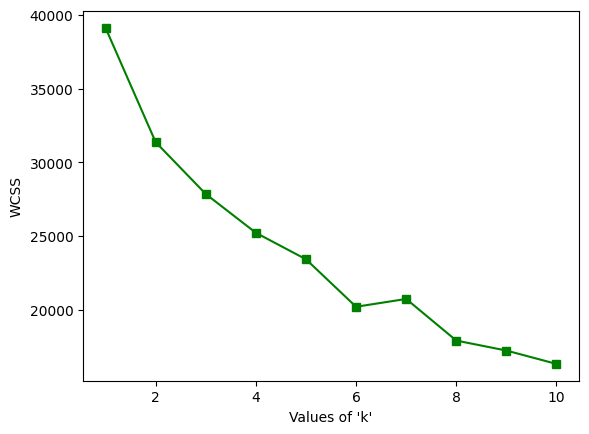

In [6]:
wcss = {} 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss[i] = kmeans.inertia_
    
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

silhouette_scores = {}
for k in range(1, 11):
    kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels_k = kmeans_model.fit_predict(X)
    if k == 1:
        silhouette_scores[k] = None  # Silhouette score is not defined for k=1
    else:
        silhouette_scores[k] = silhouette_score(X, labels_k)

for k, score in silhouette_scores.items():
    print(f"k={k}: Silhouette Score = {score:.4f}" if score is not None else f"k={k}: Silhouette Score = N/A")

k=1: Silhouette Score = N/A
k=2: Silhouette Score = 0.2620
k=3: Silhouette Score = 0.1525
k=4: Silhouette Score = 0.1633
k=5: Silhouette Score = 0.1581
k=6: Silhouette Score = 0.1788
k=7: Silhouette Score = 0.1735
k=8: Silhouette Score = 0.1905
k=9: Silhouette Score = 0.1603
k=10: Silhouette Score = 0.1878


In [8]:
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.262 | CH Score=877
k=3 | Silhouette=0.153 | CH Score=717
k=4 | Silhouette=0.163 | CH Score=651
k=5 | Silhouette=0.158 | CH Score=594
k=6 | Silhouette=0.179 | CH Score=663
k=7 | Silhouette=0.173 | CH Score=523
k=8 | Silhouette=0.190 | CH Score=599
k=9 | Silhouette=0.160 | CH Score=562


In [9]:
kmeans=KMeans(n_clusters=5)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_8294/2371074905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_left['cluster'] = kmeans.fit_predict(X)


In [10]:
kmeans.cluster_centers_

array([[ 0.18688052, -0.75169754, -0.27906146, -0.59127286,  0.        ,
        -0.04611709, -0.61564514, -0.72249143, -0.52470838,  0.1175434 ,
        -0.15864821, -0.27337737],
       [ 0.17363198, -0.13043303,  1.84565803,  1.17917482,  0.        ,
        -0.13916622, -0.21461222,  0.01004939, -0.62980131, -0.63150348,
         1.18846951,  0.52018428],
       [ 0.18688052,  0.25137521, -0.32254835, -0.06571825,  0.        ,
        -0.02872528,  0.21216604,  0.26229785,  0.88629463,  0.53034086,
         0.09457889, -0.26650002],
       [ 0.16165094,  1.7924447 ,  0.0517092 ,  0.99957638,  0.        ,
         0.25689894,  1.55828219,  1.54704538, -0.1699195 , -1.27714925,
        -0.8906838 ,  1.1570863 ],
       [-5.35101237, -0.20731264, -0.17267791, -0.43546322,  0.        ,
         0.36831313, -0.18942017, -0.24091214, -0.35447904,  0.11804986,
        -0.06287597, -0.23922907]])

In [11]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.603583,-1.057177
1,-3.577218,-2.030540
2,-1.936266,-0.293112
3,0.183542,-1.384699
4,-1.553076,-0.032871


In [12]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-1.32009331,  0.01036503],
       [ 0.7851093 ,  2.57908965],
       [ 0.00660277, -0.65959789],
       [ 3.49961333, -0.59856909],
       [-0.73961105, -0.15953616]])

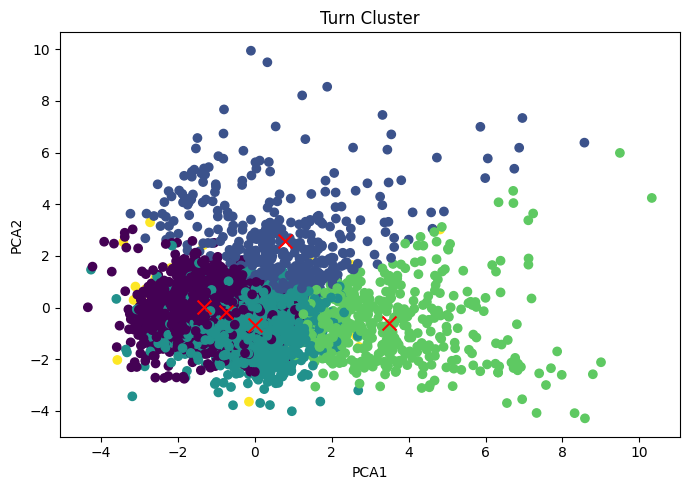

In [13]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [14]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4
is_ios,1.000000,0.997596,1.000000,0.995455,0.000000
eventType,4.000000,4.000000,4.000000,4.000000,4.000000
eventSampleSpeed,10.078629,14.215965,16.760462,27.003662,13.704065
eventDurationSeconds,5.135708,9.900882,5.037022,5.877151,5.372292
eventMilesDriven,0.014762,0.041296,0.022614,0.038527,0.017083
eventSensorDetectionMthd,1.000000,1.000000,1.000000,1.000000,1.000000
eventGPSSignalStrength,5.777569,5.544829,5.820340,6.518175,6.779356
eventStartSpeed,8.232023,11.676115,15.270740,26.665478,11.858081
eventEndSpeed,12.353281,17.472403,19.275338,28.310571,15.735596
memsMedianHorizontalNorm,1.639110,1.553600,2.762566,1.921268,1.774460


In [15]:
kmeans=KMeans(n_clusters=7)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_8294/1366429012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_left['cluster'] = kmeans.fit_predict(X)


In [16]:
kmeans.cluster_centers_

array([[ 0.18688052, -0.73059631,  2.27756323,  0.68424215,  0.        ,
        -0.08942642, -0.39850153, -0.91083114, -0.68688071,  0.42433527,
         2.87844214, -0.53675813],
       [ 0.18688052, -0.80299099, -0.31834245, -0.63389842,  0.        ,
        -0.05021141, -0.65696883, -0.77481077, -0.51279986,  0.20596425,
        -0.14821737, -0.39218873],
       [ 0.18688052,  2.19298534, -0.23471952,  0.85273164,  0.        ,
         0.4527635 ,  1.9136737 ,  1.85540783, -0.02657831, -1.30721831,
        -1.10845003,  1.15759046],
       [-5.35101237, -0.22743616, -0.19802815, -0.47164473,  0.        ,
         0.38546847, -0.21083151, -0.25636147, -0.34404909,  0.1355227 ,
        -0.06282757, -0.2379338 ],
       [-0.05924805,  1.4284885 ,  2.75305057,  3.60810196,  0.        ,
        -0.09476225,  1.24333135,  1.36203734, -0.70714379, -1.29495275,
         0.91260982,  0.96283048],
       [ 0.18688052,  0.15473947,  0.40407811,  0.41621259,  0.        ,
        -0.1328202 , -

In [17]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.603583,-1.057177
1,-3.577218,-2.030540
2,-1.936266,-0.293112
3,0.183542,-1.384699
4,-1.553076,-0.032871


In [18]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-1.02325523,  3.60840048],
       [-1.4749215 , -0.02098497],
       [ 3.92555666, -1.17847481],
       [-0.78753346, -0.18695892],
       [ 4.20259271,  3.33255035],
       [ 0.91529312,  0.48565303],
       [-0.19407506, -0.85022605]])

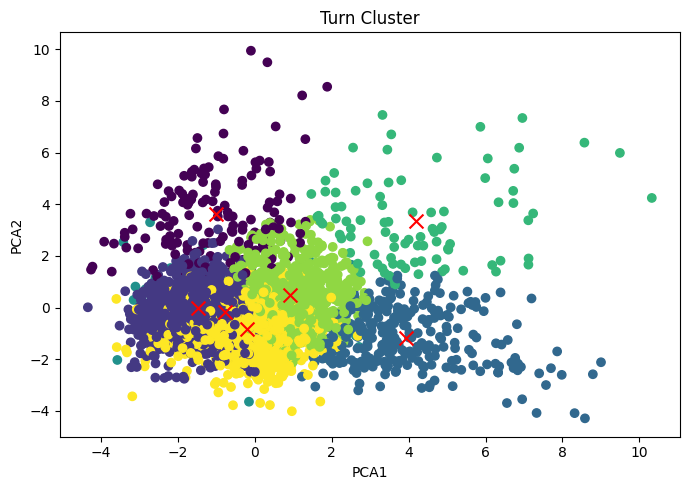

In [19]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [20]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4,5,6
is_ios,1.000000,1.000000,1.000000,0.000000,0.955556,1.000000,1.000000
eventType,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
eventSampleSpeed,10.217242,9.734851,29.698091,13.569974,24.603981,16.116545,16.646889
eventDurationSeconds,10.853633,5.046431,5.233501,5.315582,11.917327,6.662531,4.781135
eventMilesDriven,0.033832,0.014115,0.036352,0.016542,0.077566,0.029822,0.020897
eventSensorDetectionMthd,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
eventGPSSignalStrength,5.673721,5.768441,6.983340,6.820794,5.660832,5.568906,5.919836
eventStartSpeed,10.081318,7.884876,29.730066,11.676129,24.033531,13.192186,15.592461
eventEndSpeed,11.023167,11.979979,30.481793,15.626920,27.011264,19.719588,18.823538
memsMedianHorizontalNorm,1.509747,1.648379,2.035588,1.782766,1.493610,1.857743,2.892932


In [21]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_8294/208876394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_left['cluster'] = kmeans.fit_predict(X)


In [22]:
kmeans.cluster_centers_

array([[ 8.31447792e-02,  1.29987195e+00,  5.60396871e-01,
         1.18458463e+00,  0.00000000e+00,  1.19590562e-01,
         1.07442915e+00,  1.19947929e+00, -2.51953533e-01,
        -1.15364422e+00, -4.15438358e-01,  1.08778148e+00],
       [-1.28768848e-01, -7.27293708e-01,  4.30705670e-02,
        -4.21366477e-01,  0.00000000e+00, -3.58034223e-02,
        -6.02670060e-01, -6.93534753e-01, -6.15424254e-01,
         1.14224796e-03,  8.59910150e-02, -2.18931376e-01],
       [ 1.13502365e-01,  1.91960740e-01, -3.56137064e-01,
        -1.22185552e-01,  0.00000000e+00, -2.06252896e-02,
         1.60531718e-01,  2.04717655e-01,  8.93694972e-01,
         6.22623132e-01,  1.18888860e-01, -3.18961576e-01]])

In [23]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

centers=pca.transform(kmeans.cluster_centers_)

#Reduced Features
reduced_X.head()


,PCA1,PCA2
0,0.603583,-1.057177
1,-3.577218,-2.030540
2,-1.936266,-0.293112
3,0.183542,-1.384699
4,-1.553076,-0.032871


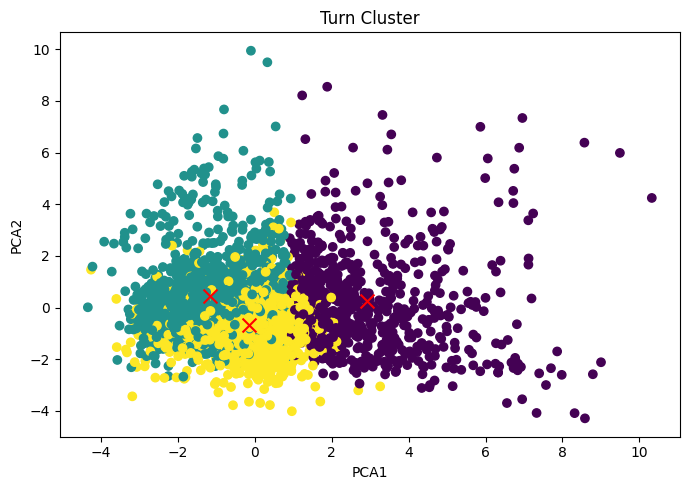

In [24]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [25]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
is_ios,0.981268,0.942966,0.986760
eventType,4.000000,4.000000,4.000000
eventSampleSpeed,23.746964,10.239830,16.359078
eventDurationSeconds,7.012225,5.856013,4.961252
eventMilesDriven,0.041316,0.017299,0.021759
eventSensorDetectionMthd,1.000000,1.000000,1.000000
eventGPSSignalStrength,6.178586,5.800583,5.843145
eventStartSpeed,22.598209,8.349552,14.822913
eventEndSpeed,25.867778,12.550101,18.867345
memsMedianHorizontalNorm,1.856107,1.566038,2.768279


In [26]:
sub_df_left.head()

,is_ios,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,cluster
3,0,4.0,19.864027,5.356430,0.025984,1,20.663265,22.033857,18.588970,2.522688,16.592813,89.536600,12.669695,2
5,0,4.0,6.151584,2.975500,0.004350,1,19.897959,2.594850,8.276677,3.189065,27.415617,82.662840,10.975670,1
6,0,4.0,8.474273,5.634813,0.012433,1,22.193878,11.811042,3.869906,1.813293,15.221751,86.375750,9.263290,1
7,0,4.0,18.418962,4.722125,0.021606,1,17.346940,17.850780,21.810163,3.041614,19.948822,94.992430,19.639070,2
10,0,4.0,6.882319,6.110883,0.011723,1,21.428572,11.229438,3.937014,1.928998,14.422221,88.704796,29.668463,1
